In [1]:
%matplotlib inline 
from __future__ import division
from pylab import *
import skimage as ski
from skimage import data, io, filters, exposure
from skimage.filters import rank
from skimage import img_as_float, img_as_ubyte
from skimage.morphology import disk
import skimage.morphology as mp
from skimage import util
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
from skimage.filters.edges import convolve
from matplotlib import pylab as plt
import numpy as np
from numpy import array
from IPython.display import display
from ipywidgets import interact, interactive, fixed
from ipywidgets import *
from ipykernel.pylab.backend_inline import flush_figures
from skimage import measure 
from PIL import ImageEnhance
from PIL import Image
import matplotlib.patches as patches
from PIL import ImageDraw
from operator import itemgetter
from collections import Counter

import cv2 as cv
import pandas as pd
import glob

In [2]:
######## WAITING ROOM FOR USELESS PARTS ############3 

# PART 7 
def treshold2(name):
    import cv2 as cv
    import numpy as np
    from matplotlib import pyplot as plt
    img = cv.imread(name,0)
    # global thresholding
    ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
    # Otsu's thresholding
    ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    # Otsu's thresholding after Gaussian filtering
    blur = cv.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    # plot all the images and their histograms
    images = [img, 0, th1,
              img, 0, th2,
              blur, 0, th3]
    titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
              'Original Noisy Image','Histogram',"Otsu's Thresholding",
              'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
    for i in range(3):
        plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
        plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
        plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
        plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
        plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
        plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
    plt.show()
    
# PART 6 

def treshold_Otsu(name):
    img = cv.imread(name,0)
    blur = cv.GaussianBlur(img,(5,5),0)
    # find normalized_histogram, and its cumulative distribution function
    hist = cv.calcHist([blur],[0],None,[256],[0,256])
    hist_norm = hist.ravel()/hist.max()
    Q = hist_norm.cumsum()
    bins = np.arange(256)
    fn_min = np.inf
    thresh = -1
    for i in range(1,256):
        p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
        q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
        b1,b2 = np.hsplit(bins,[i]) # weights
        # finding means and variances
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
        # calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
    # find otsu's threshold value with OpenCV function
    ret, otsu = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    print( "{} {}".format(thresh,ret) )
    
# PART 5 

def tresholding(name):
    img = cv.imread(name,0)
    img = cv.medianBlur(img,5)
    ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)

    th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
                cv.THRESH_BINARY,11,2)
    th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv.THRESH_BINARY,11,2)
    titles = [['Original Image', 'Global Thresholding (v = 127)'],['Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']]
    images = [[img, th1],[th2, th3]]
    
    fig, axar = plt.subplots(2,2,figsize=(15, 15))
    fig.suptitle("Tresholded photos")
    
    for i in range(2):
        for xx in range(2):
            axar[i,xx].imshow(images[i][xx],interpolation = 'nearest', cmap=plt.cm.gray)
            axar[i,xx].set_title(titles[i][xx])
    plt.show()

In [3]:
# PART 0 - helpers

def distance(self, other):
    return math.sqrt((self[0] - other[0])**2 + (self[1] - other[1])**2)

def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)

def get_col(photo,i,j):
    return photo[i][j][0], photo[i][j][1], photo[i][j][2]

def max_hsv(photo, nature):
    photohsv = rgb2hsv(photo)
    ht, wh = photo.shape[0], photo.shape[1]
    result = np.copy(photo)
    for i in range (ht):
        for j in range (wh):
            h,s,v = get_col(photohsv,i,j)
            if(nature == 'hue'):
                result[i][j] = [1,s,v]
            elif(nature == 'saturation'):
                result[i][j] = [h,1,v]
            if(nature == 'value'):
                result[i][j] = [h,s,1]
    return hsv2rgb(result)

In [4]:
# PART 1 

def przytnij(zdjecie):
    plansza = np.copy(zdjecie)
    size = plansza.shape
    height,width  = size[0],size[1]    
    
    for i in range(0, size[0]):
        for j in range(0, size[1]):
            r,g,b = get_col(plansza,i,j)
            if r < 0.1 :
                r,g,b = [1.0,1.0,1.0]
            else:
                r,g,b = [0.0,0.0,0.0]

            plansza[i][j] = [r,g,b]

    # find eye border
    plansza = rgb2gray(plansza)
    kontury = measure.find_contours(plansza, 0.8)
   
    # choose the biggest ( usually only 1, but if >1 -> choose the biggest) 
    kontury = sorted(kontury, key=len)[-1:] 
    print("Detected:",len(kontury), "contour(s)")
    wielkosc = [max(l[:,0])-min(l[:,0]) for l in kontury]
    x = wielkosc.index(min(wielkosc))
    kontur = kontury[x]

    # find borders which determine 'range points'
    gorny,dolny,prawy,lewy = int(min(kontur[:,0])),int(max(kontur[:,0])),int(max(kontur[:,1])),int(min(kontur[:,1]))
    srodek =[(gorny+dolny)/2, (prawy+lewy)/2] 
    promien = (prawy-lewy)/2
    
    for i in range(height):
        for j in range(width):
            if distance([i,j], srodek) > promien:
                # wyostrzenie niepotrzebnych wartosci
                zdjecie[i][j] = [0,1,0]
                
    #cut to edges to reduce black pixels
    wyciete = zdjecie[gorny:dolny, lewy:prawy]
    
    fig, zzzx = plt.subplots(1,1,figsize=(10,10))
    zzzx.set_title("Cutted (withoud black and with sharp b-ground)")
    zzzx.imshow(wyciete, interpolation = 'nearest', cmap=plt.cm.gray)
    
    return wyciete

In [5]:
# PART 2,3,4

def hsv_checker(i):
    hue1,saturated1,valued1 = max_hsv(i,'hue'),max_hsv(i,'saturation'),max_hsv(i,'value')
    photos = [[i,hue1],[saturated1,valued1]]
    legend = [["Original","Hue = 1"],["Saturaton = 1","Value = 1"]]
    #H,S,V = 1
    #Matplotlib party
    fig, axar = plt.subplots(2,2,figsize=(15, 15))
    fig.suptitle("Influence of maximized h,s,v values on original")
    for i in range(2):
        for xx in range(2):
            axar[i,xx].imshow(photos[i][xx],interpolation = 'nearest', cmap=plt.cm.gray)
            axar[i,xx].set_title(legend[i][xx])
    plt.show()
    
def hhssvv_checker(i):
    hue1,saturated1,valued1 = max_hsv(i,'hue'),max_hsv(i,'saturation'),max_hsv(i,'value')
    hue_saturated1,hue_valued1,saturated_value1 = max_hsv(hue1,"saturation"),max_hsv(valued1,"value"),max_hsv(saturated1,'value')
    photos2 = [[i,hue_saturated1],[hue_valued1,saturated_value1]]
    legend2 = [["Original","H,S = 1"],["H,V = 1","S,V = 1"]]
    #HS,HV,SV = 1
    #Matplotlib party
    fig, axar = plt.subplots(2,2,figsize=(15, 15))
    fig.suptitle("Influence of maximized h,s,v values on original")
    for i in range(2):
        for xx in range(2):
            axar[i,xx].imshow(photos2[i][xx],interpolation = 'nearest', cmap=plt.cm.gray)
            axar[i,xx].set_title(legend2[i][xx])
    plt.show()
        
def grey_checker_basic(i):
    gray = rgb2gray(i)
    fig,csx = plt.subplots(1,1,figsize=(15,15))
    csx.set_title("Original photo in grey scale")
    csx.imshow(gray, interpolation = 'nearest', cmap=plt.cm.gray)
    
def grey_checker_conturs(i):
    vessels = [[],[]]
    original = i     
        
    nasycone = max_hsv(i,'saturation')
    #fig, aax = plt.subplots()
    #aax.imshow(nasycone, interpolation = 'nearest', cmap=plt.cm.gray)
    
    nasycone = max_hsv(nasycone,'value')
    nasycone = filters.gaussian(nasycone)
    #fig, abx = plt.subplots()
    #abx.imshow(nasycone, interpolation = 'nearest', cmap=plt.cm.gray)
    
    nasyconehsv = rgb2hsv(nasycone)
    #fig, acx = plt.subplots()
    #acx.imshow(nasyconehsv, interpolation = 'nearest', cmap=plt.cm.gray)
    
    photohsv = rgb2hsv(i)
    #fig, ad = plt.subplots()
    #ad.imshow(photohsv, interpolation = 'nearest', cmap=plt.cm.gray)
    
    size = nasycone.shape
    temp = np.copy(i)
    whitevessels = np.copy(i)
    
    for k in range (2):
        for i in range(size[0]):
            for j in range(size[1]):
                r,g,b = get_col(nasycone,i,j)
                h,s,v = get_col(nasyconehsv,i,j)
                hp,sp,vp = get_col(photohsv,i,j)

                #white
                if k ==0 and (  (h <0.1 or h >0.986) and (v > 0.5 and v < 0.7) and sp > 0.6):
                    r,g,b = [1.0,1.0,1.0]
                    whitevessels[i][j] = [r,g,b]
                else:
                    r,g,b = [0.0,0.0,0.0]
                    
                temp[i][j] = [r, g, b]

        gray = rgb2gray(temp)
        gray = (gray == 1) * 255
        gray = np.uint8(gray)

        vessels[k] = measure.find_contours(gray, 0.8)
    
    print("Wykryte kontury:")
    for n,kontur in enumerate(vessels[1]):
        ax.plot(kontur[:, 1], kontur[:, 0], linewidth=1)
        


In [6]:
# PART 8 
import cv2 as cv2

def sobel(name):
    img = cv2.imread(name,0)

    laplacian = cv2.Laplacian(img,cv2.CV_64F)
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

    plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
    plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
    plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
    plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

    plt.show()

In [7]:
# PART 9
import cv2 as cv
def canny_edge(name):
    img = cv.imread(name,0)
    edges = cv.Canny(img,100,200)
    plt.subplot(121),plt.imshow(img,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.show()

In [8]:
# PART 10
def laplace(name):
    import cv2
    img = cv2.imread(name,0)

    laplacian = cv2.Laplacian(img,cv2.CV_64F)
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

    plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
    plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
    plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
    plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

    plt.show()

# Plan pracy:  

### Blok 1 - hsv,measures

#### 1. Przycięcie zdjęcia do maksymalnych pixeli(up,down,left,right). Zastąpienie czarnego krzykliwym hsv-kiem ( przyjemnego do dalszych filtracji)
#### 2 Przegląd zdjęcia z wymaksowanymi wartościami: 2.1.h,s,v /// 2.2 hs,hv,sv
#### 3. Przegląd zdjęcia w szarości
#### 4. Wstępna próba nałożenia konturów na naczynia

### Wnioski: hsv działa spoko ale pomija pewne części (TODO ! lepsze wykrywania błękitu w hsv) + Działanie konturów ?? ( TODO ! )


##### ---------------------------------------------------------------

### Blok 2 - treshold


#### 5. Przegląd zdjęcia w tresholdzie 
#### 6. Współczynnik O'tsu  
#### 7. Treshold 2 

## Wnioski: Treshold + Mean/Gauus działa mega spoko i na tym bedziemy oprzemy niemaszynowe wykrywanie naczyń (TODO ! )

##### ---------------------------------------------------------------

### Blok 3 - funkcje morfologiczne

#### 8. Sobel 

#### 9. Canny edge

#### 10. Laplace

## Wnioski: Laplace słabo, Sobel X,Y złożone całkiem spoko mogą działać, Canny edge słabo, Sobel w miarę.

##### ---------------------------------------------------------------

### Blok 4 - podsumowanie

######  Info: Punkty  wykorzy ze strony poglądowo i w przypadku korzystania z nich w szerszej implementacji, będa stworzone od początku, bez gotowych wzorców.  ( poszukiwanie najlepszej strategii przetwarzania). 

###### Punkty 5-7  https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html

###### Punkt 8 https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html
###### Punkt 10. https://docs.opencv.org/3.1.0/d5/d0f/tutorial_py_gradients.html


# SUM UP - jedziemy tresholdem z gausem i medianą - najlepsza skutecznosc

Detected: 1 contour(s)


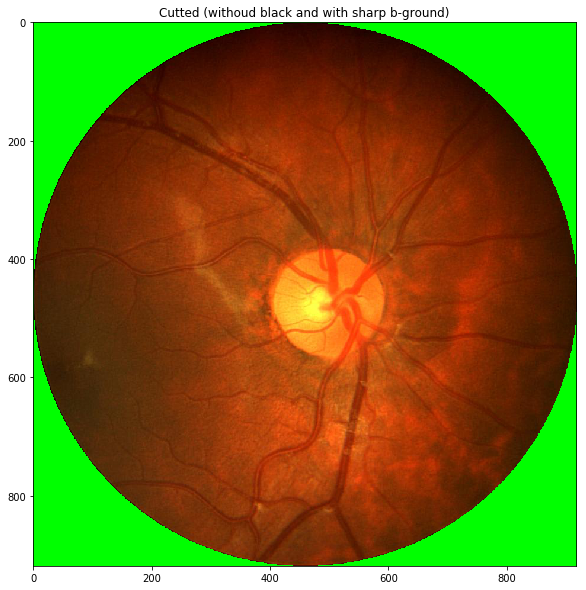

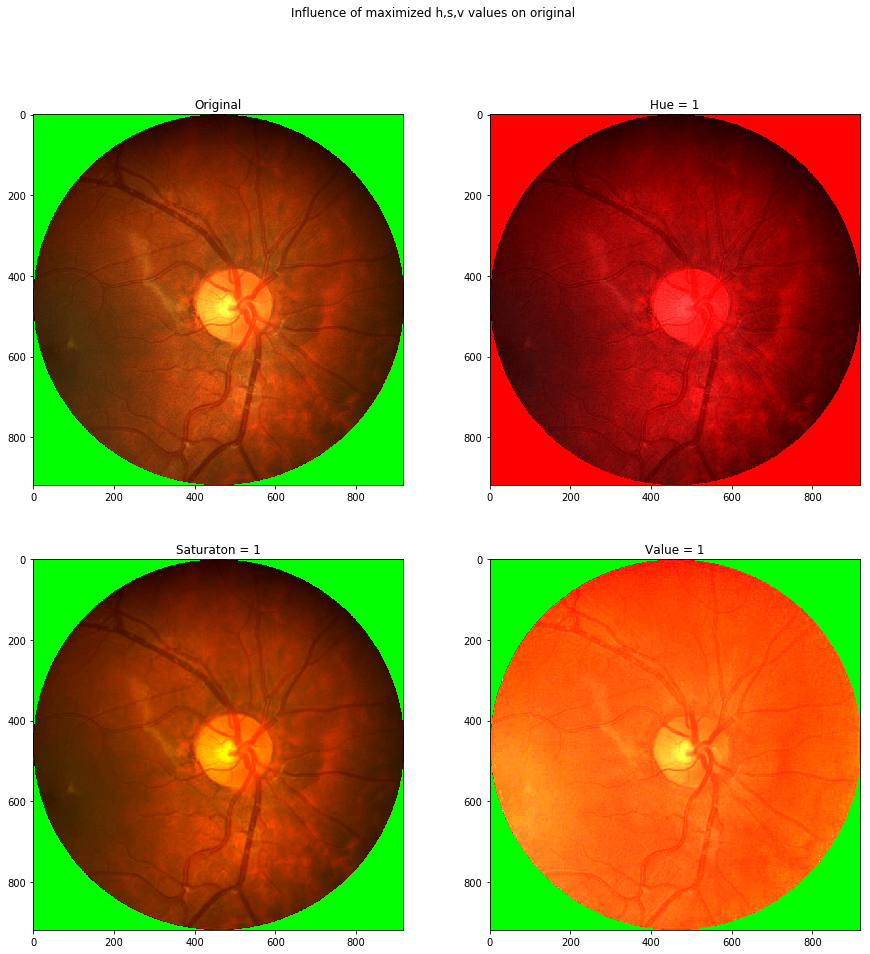

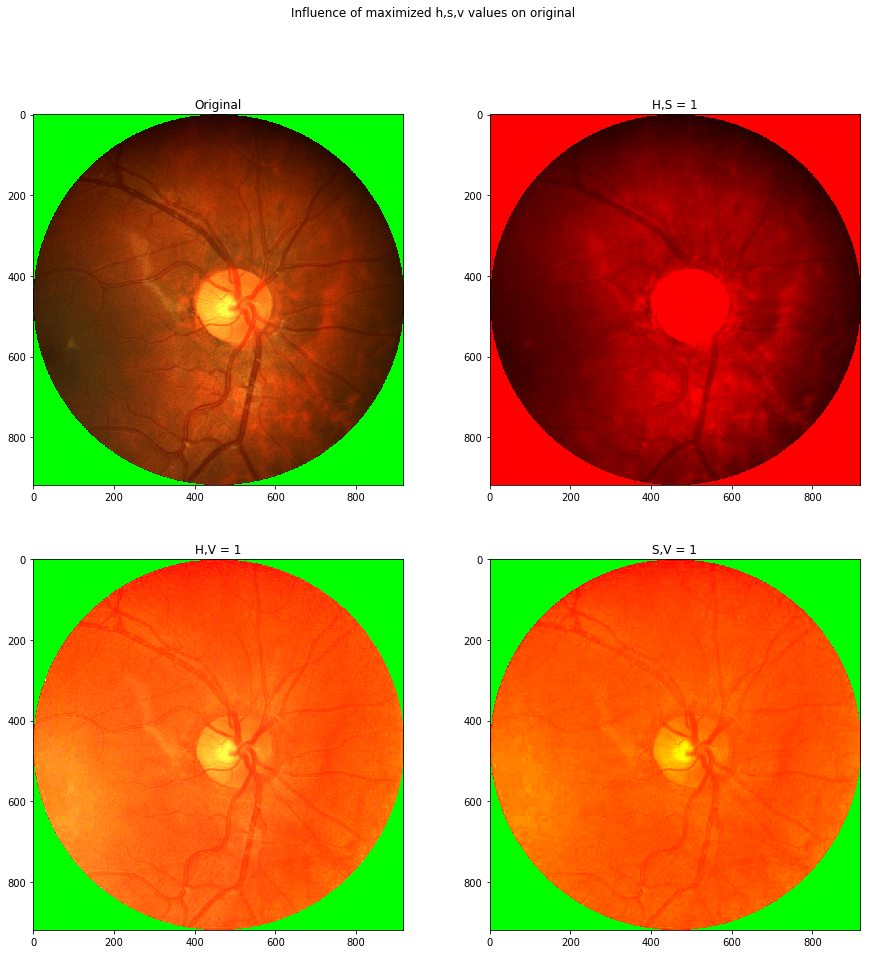

D:\Anaconda\lib\site-packages\skimage\filters\_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Wykryte kontury:


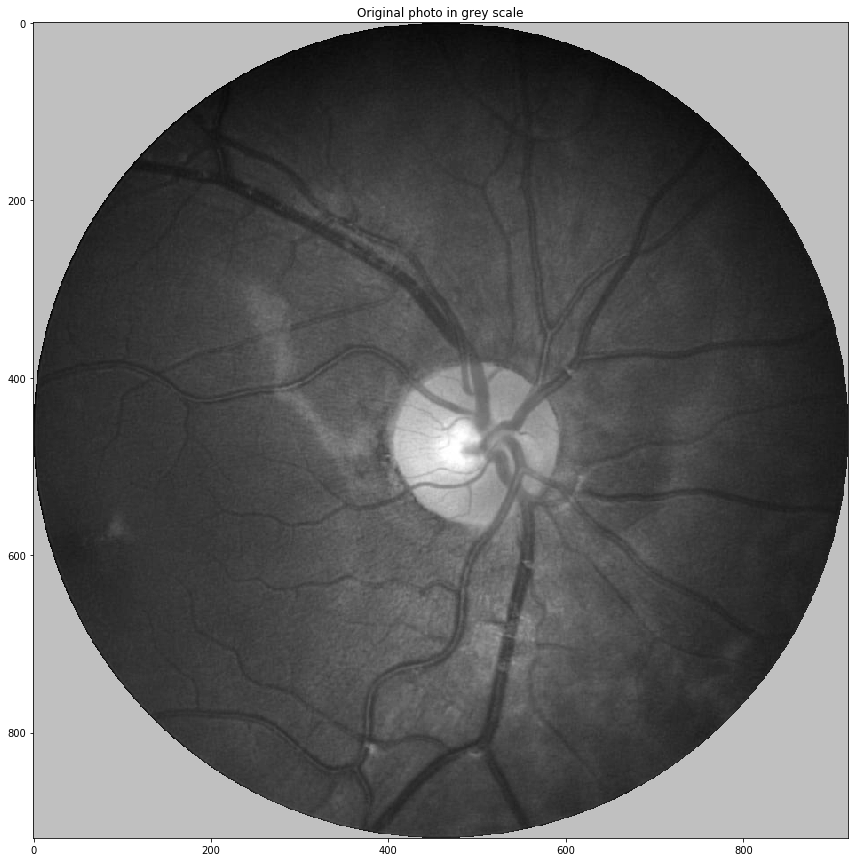

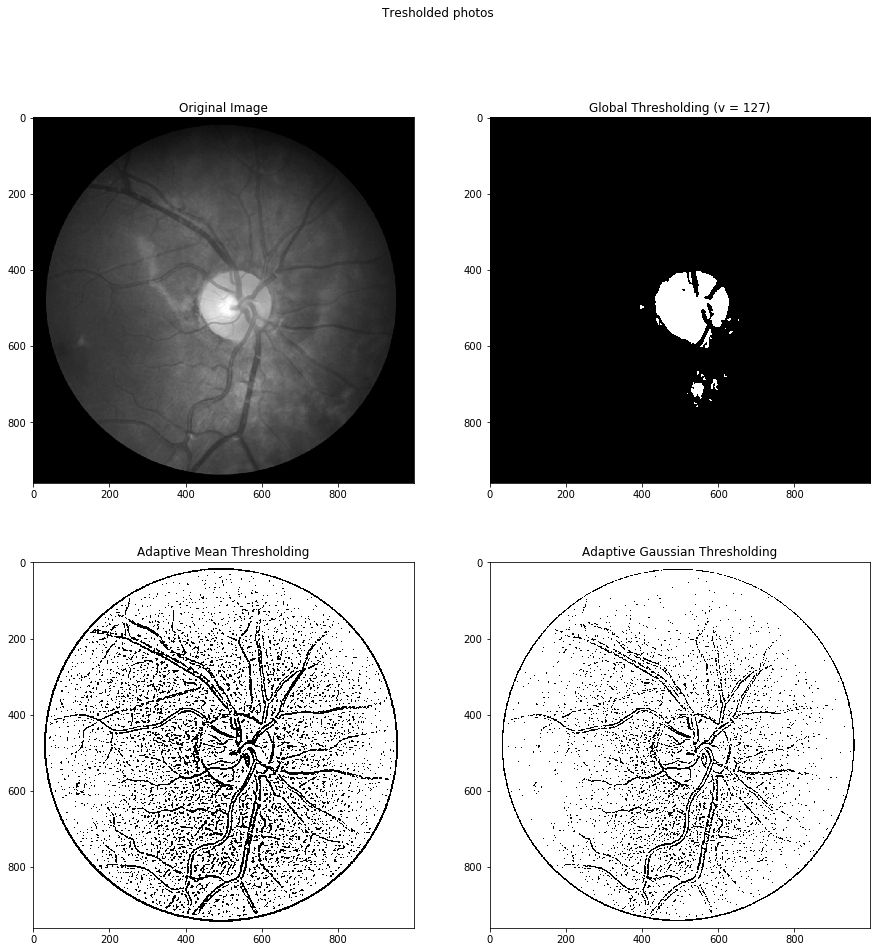

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in double_scalars
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


44 43.0


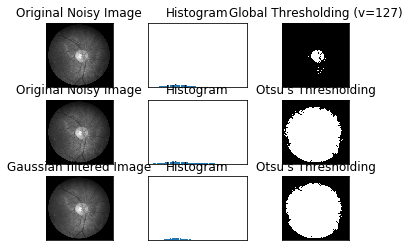

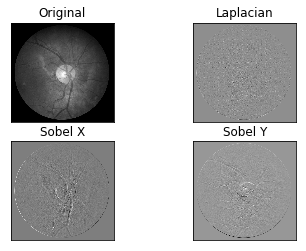

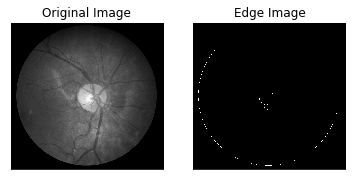

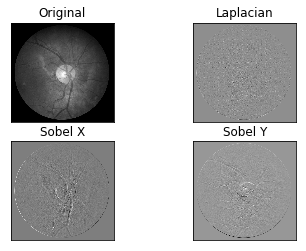

In [9]:
def blood_vessels(photo,name):
    #--------------BLOK 1--------------------- #
    i = przytnij(photo)       #1
    hsv_checker(i)            #2.1
    hhssvv_checker(i)         #2.2
    grey_checker_basic(i)     #3 
    grey_checker_conturs(i)   #4 #NOT WORKING PROPERLY -> FIX measures
    
    #--------------BLOK 2----------------------#
    tresholding(name)         #5
    treshold_Otsu(name)       #6
    treshold2(name)           #7
    
    #-------------BLOK 3-----------------------#
    sobel(name)               #8
    canny_edge(name)          #9
    laplace(name)             #10

def photo_hoover():
    file_names = [fn for fn in glob.glob("CHASEDB1/*" + "01R.JPG")] # narazie na jednym pozniej sie nazwe zmieni na * zeby puścić all 
    for i in file_names:
        blood_vessels(img_as_float(ski.io.imread(i)),i)
    
if __name__ == "__main__":
    photo_hoover()

### TODO ! 

# 4. - Naprawić measures , 5. - Przetworzyć fotki tresholdem i filtrami: medianowym,gausowskim 